In [ ]:
import pandas as pd
import re
import numpy as np
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import os
import tensorflow as tf
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import string
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
#Acquire the dataset from AllReviews csv file and clean it up to a usable form
AllReviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AllReviews.csv')
AllReviews = AllReviews.loc[(AllReviews["titleType"] == "tvMovie")|(AllReviews["titleType"] == "movie")]

# Filter relevant columns and remove duplicates
Reviews_Genres_Title = AllReviews[["Review", "genres"]].drop_duplicates()
# Remove rows with missing reviews
Reviews_Genres_Title = Reviews_Genres_Title.dropna(subset=["Review"])
# Remove rows with undefined genres
Reviews_Genres_Title = Reviews_Genres_Title[Reviews_Genres_Title["genres"] != '\\N']

# Copy for further processing
Complete_Reviews = Reviews_Genres_Title.copy()
# Convert reviews to lowercase
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.lower()
# Replace periods and commas
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('[,.]', ' ', regex=True)
# Remove newlines
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('\n', '', regex=False)
# Remove HTML tags
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('<[^>]+>', '', regex=True)
# Remove non-alphanumeric characters
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('[^A-Za-z0-9 ]+', '', regex=True)
Complete_Reviews.reset_index(drop=True, inplace=True)

In [ ]:
## DistilGPT2 pretrained
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/distilgpt_reviews.csv')
## DistilGPT2 finetuned
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/distilgpt_finetuned_reviews.csv')
## GRU Reviews
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/GRU_GenReviews (1).csv')
## Unigram Reviews
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/unigram_reviews.csv')
## Bigram Reviews
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/bigram_reviews.csv')
# Trigram Reviews
New_Reviews = pd.read_csv('/content/drive/MyDrive/results/trigram_reviews.csv')

New_Reviews = New_Reviews.rename(str.lower, axis='columns')

# Remove Prompt - DistilGPT2
New_Reviews['review'] = New_Reviews['review'].str.replace('^write a movie review:', '', regex=True)
# Remove Prompt - GRU
New_Reviews['review'] = New_Reviews['review'].str.replace('^and then ', '', regex=True)
# Convert reviews to lowercase
New_Reviews['review'] = New_Reviews['review'].str.lower()
# Replace periods and commas
New_Reviews['review'] = New_Reviews['review'].str.replace('[,.]', ' ', regex=True)
# Remove newlines
New_Reviews['review'] = New_Reviews['review'].str.replace('\n', '', regex=False)
# Remove HTML tags
New_Reviews['review'] = New_Reviews['review'].str.replace('<[^>]+>', '', regex=True)
# Remove non-alphanumeric characters
New_Reviews['review'] = New_Reviews['review'].str.replace('[^A-Za-z0-9 ]+', '', regex=True)

fake_reviews = pd.DataFrame({'Review': New_Reviews['review'], 'Label': 'fake'})

In [ ]:
# Randomly select an equal number of real reviews for classification training
points = np.random.choice(list(range(Complete_Reviews.shape[0])), size = fake_reviews.shape[0], replace = False)
real_reviews = Complete_Reviews['Review'][points]
real_reviews = pd.DataFrame({'Review': real_reviews, 'Label': 'real'})

In [ ]:
reviews = pd.concat([real_reviews, fake_reviews]).reset_index(drop=True)
reviews = reviews.sample(frac=1, random_state=42).reset_index(drop=True)
reviews

,Review,Label
0,into callous selfcentered monsters and a few m...,fake
1,it was clear right from the beginning that 911...,real
2,alan johnson don cheadle is a successful denti...,real
3,i saw deadly target in a hotel room in zhuhai ...,real
4,this film which i just saw is extremely powerf...,real
...,...,...
9995,deeply distrustful relationship with the filmm...,fake
9996,countess title and no point to the bed my chai...,fake
9997,share i rate this scifi classic for anyone if ...,fake
9998,critters 4 starts i quote somewhere in kansa...,real


In [ ]:
all_data = reviews['Review']
all_labels = reviews['Label']

split_point = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    all_data, all_labels, train_size = split_point)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
def get_mlp_classifier(train_data, train_labels, **kwargs):
  model = make_pipeline(TfidfVectorizer(), MLPClassifier(**kwargs))
  model.fit(train_data, train_labels)
  return model

model = get_mlp_classifier(X_train, y_train, hidden_layer_sizes = (100,), verbose = True)

Iteration 1, loss = 0.64296848
Iteration 2, loss = 0.48337615
Iteration 3, loss = 0.30700357
Iteration 4, loss = 0.18418290
Iteration 5, loss = 0.11483247
Iteration 6, loss = 0.07618263
Iteration 7, loss = 0.05361870
Iteration 8, loss = 0.03932003
Iteration 9, loss = 0.02996322
Iteration 10, loss = 0.02370976
Iteration 11, loss = 0.01923670
Iteration 12, loss = 0.01604104
Iteration 13, loss = 0.01364450
Iteration 14, loss = 0.01180759
Iteration 15, loss = 0.01037429
Iteration 16, loss = 0.00924260
Iteration 17, loss = 0.00833999
Iteration 18, loss = 0.00760103
Iteration 19, loss = 0.00698714
Iteration 20, loss = 0.00647432
Iteration 21, loss = 0.00604230
Iteration 22, loss = 0.00567440
Iteration 23, loss = 0.00535469
Iteration 24, loss = 0.00507950
Iteration 25, loss = 0.00484012
Iteration 26, loss = 0.00463037
Iteration 27, loss = 0.00444306
Iteration 28, loss = 0.00427963
Iteration 29, loss = 0.00413039
Iteration 30, loss = 0.00399599
Iteration 31, loss = 0.00387525
Iteration 32, los

In [ ]:
y_pred = model.predict(X_test)

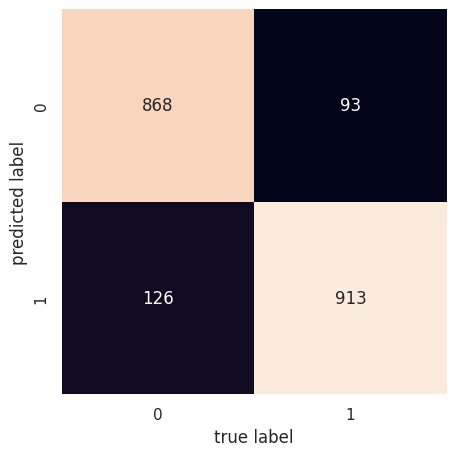

In [ ]:
def get_confusion_matrix(test_labels, pred_labels):
    sns.set()
    mat = confusion_matrix(test_labels, pred_labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')

get_confusion_matrix(y_test, y_pred)

In [ ]:
def get_f1_scores(test_labels, pred_labels):
    f1 = f1_score(test_labels, pred_labels, pos_label = 'real')
    print("F1 Score:", round(100*f1, 2), "%")

get_f1_scores(y_test, y_pred)

F1 Score: 89.29 %


Iteration 1, loss = 0.63361519
Iteration 2, loss = 0.29169283
Iteration 3, loss = 0.05981805
Iteration 4, loss = 0.01495097
Iteration 5, loss = 0.00582621
Iteration 6, loss = 0.00307951
Iteration 7, loss = 0.00195841
Iteration 8, loss = 0.00139327
Iteration 9, loss = 0.00107721
Iteration 10, loss = 0.00088839
Iteration 11, loss = 0.00076775
Iteration 12, loss = 0.00068613
Iteration 13, loss = 0.00062709
Iteration 14, loss = 0.00058088
Iteration 15, loss = 0.00054289
Iteration 16, loss = 0.00051231
Iteration 17, loss = 0.00048872
Iteration 18, loss = 0.00047061
Iteration 19, loss = 0.00045624
Iteration 20, loss = 0.00044456
Iteration 21, loss = 0.00043494
Iteration 22, loss = 0.00042653
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
F1 Score: 88.62 %


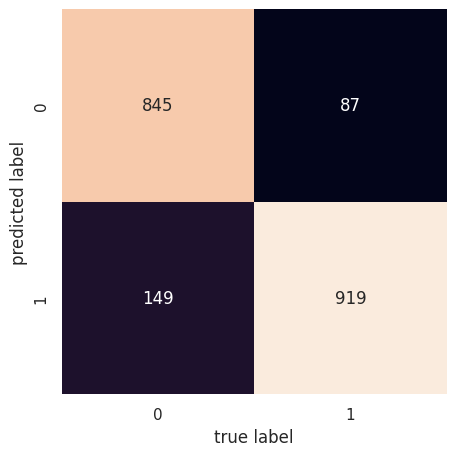

In [ ]:
model = get_mlp_classifier(X_train, y_train, hidden_layer_sizes = (100, 100), learning_rate = 'adaptive', verbose = True)
y_pred = model.predict(X_test)
get_confusion_matrix(y_test, y_pred)
get_f1_scores(y_test, y_pred)

In [ ]:
# The embed model is loaded from Google Drive
glove2word2vec('/content/drive/MyDrive/results/glove.6B.300d.txt', '/content/drive/MyDrive/results/glove.6B.300d.word2vec.txt')
embed_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/results/glove.6B.300d.word2vec.txt')

<ipython-input-14-06e4a87da033>:2: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec('/content/drive/MyDrive/results/glove.6B.300d.txt', '/content/drive/MyDrive/results/glove.6B.300d.word2vec.txt')


In [ ]:
X_train[0]

'i expected this movie to bore me within the first five minutes  but i had an afternoon to kill and there was a rerun of a home improvement show i could watch  i got a pleasant surprise and never did check into ways to repaint the kitchen  i found the plot to be original because of dillons machinations to get another guy the girl  hes not much of a matchmaker  but he seems to sincerely want hi exwife to be happy  the end was predictable  but sciorra and dillon are convincing as angry ex spouses who have gone in different directions and the numerous character actors fill in the occasional boring spots  especially dan hedeya  i like anything he does though  so i am biased '

In [ ]:
# The function was edited to use OOV_embed as a global variable instead of a parameter, so the list comprehension can work
def calc_doc_embedding(doc, embed_model, embed_size):
    global OOV_embed
    doc = doc.lower()
    stopset = set(stopwords.words('english') + list(string.punctuation))
    rwords = doc.split()
    rwords = list(set(rwords) - set(stopset))
    if(len(rwords)==0):
      return np.zeros(len(embed_model.vectors[0]))
    missing_words = [rword for rword in rwords if not embed_model.has_index_for(rword)]
    present_words = list(set(rwords) - set(missing_words))
    for missing_word in missing_words:
        if missing_word in OOV_embed:
            continue
        fill_in = np.random.randint(0, len(embed_model.vectors))
        OOV_embed[missing_word] = embed_model.vectors[fill_in]
    doc_embed1 = np.sum([embed_model.get_vector(rword) for rword in present_words], axis = 0)
    doc_embed2 = np.sum([OOV_embed[rword] for rword in missing_words], axis = 0)
    doc_embed = (doc_embed1 + doc_embed2)/len(rwords)
    return doc_embed

In [ ]:
OOV_embed = {}
X_train_embed = np.vstack([calc_doc_embedding(doc, embed_model, 100) for doc in X_train])
X_test_embed = np.vstack([calc_doc_embedding(doc, embed_model, 100) for doc in X_test])

In [ ]:
# 4 hidden layers with 400 units each
def get_mlp_classifier_embed(train_data_embed, train_labels, **kwargs):
  model = MLPClassifier(**kwargs)
  model.fit(train_data_embed, train_labels)
  return model

model = get_mlp_classifier_embed(X_train_embed, y_train, hidden_layer_sizes = (100, 100, 100, 100), learning_rate = 'adaptive', verbose = True)

Iteration 1, loss = 0.64552085
Iteration 2, loss = 0.46075723
Iteration 3, loss = 0.31709984
Iteration 4, loss = 0.24659844
Iteration 5, loss = 0.18983849
Iteration 6, loss = 0.15677270
Iteration 7, loss = 0.12999518
Iteration 8, loss = 0.09735900
Iteration 9, loss = 0.07064221
Iteration 10, loss = 0.06152241
Iteration 11, loss = 0.03274586
Iteration 12, loss = 0.02341761
Iteration 13, loss = 0.02805480
Iteration 14, loss = 0.01770880
Iteration 15, loss = 0.00795496
Iteration 16, loss = 0.00440362
Iteration 17, loss = 0.00218271
Iteration 18, loss = 0.00111674
Iteration 19, loss = 0.00079160
Iteration 20, loss = 0.00068660
Iteration 21, loss = 0.00060910
Iteration 22, loss = 0.00054841
Iteration 23, loss = 0.00050139
Iteration 24, loss = 0.00046206
Iteration 25, loss = 0.00042430
Iteration 26, loss = 0.00039133
Iteration 27, loss = 0.00034841
Iteration 28, loss = 0.00030828
Iteration 29, loss = 0.00027381
Iteration 30, loss = 0.00024710
Iteration 31, loss = 0.00022755
Training loss did

F1 Score: 88.29 %


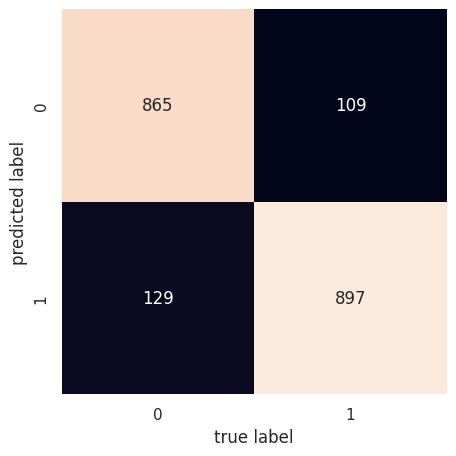

In [ ]:
y_pred = model.predict(X_test_embed)
get_confusion_matrix(y_test, y_pred)
get_f1_scores(y_test, y_pred)

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder().fit(all_labels)
y_train_num = le.transform(y_train)
y_test_num = le.transform(y_test)

In [ ]:
train_tensor = tf.data.Dataset.from_tensor_slices((X_train, y_train_num))

test_tensor = tf.data.Dataset.from_tensor_slices((X_test, y_test_num))

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_tensor = train_tensor.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_tensor = test_tensor.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 50000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_tensor.map(lambda text, label: text))

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_tensor, epochs=10,
                    validation_data=test_tensor,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_tensor)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/10
125/125 [==============================] - 246s 2s/step - loss: 1.4147 - accuracy: 0.5235 - val_loss: 0.6868 - val_accuracy: 0.9807
Epoch 2/10
125/125 [==============================] - 234s 2s/step - loss: 0.3836 - accuracy: 0.9279 - val_loss: 0.1405 - val_accuracy: 0.9745
Epoch 3/10
125/125 [==============================] - 233s 2s/step - loss: 0.1058 - accuracy: 0.9758 - val_loss: 0.0798 - val_accuracy: 0.9802
Epoch 4/10
125/125 [==============================] - 271s 2s/step - loss: 0.0637 - accuracy: 0.9834 - val_loss: 0.0768 - val_accuracy: 0.9771
Epoch 5/10
125/125 [==============================] - 236s 2s/step - loss: 0.0402 - accuracy: 0.9875 - val_loss: 0.0796 - val_accuracy: 0.9755
Epoch 6/10
125/125 [==============================] - 227s 2s/step - loss: 0.0224 - accuracy: 0.9924 - val_loss: 0.0999 - val_accuracy: 0.9651
Epoch 7/10
125/125 [==============================] - 232s 2s/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0711 - val_accuracy: 0.9776

In [ ]:
y_pred_num = model.predict(test_tensor)
y_pred = [le.classes_[np.argmax(x)] for x in y_pred_num]

32/32 [==============================] - 17s 418ms/step


F1 Score: 97.17 %


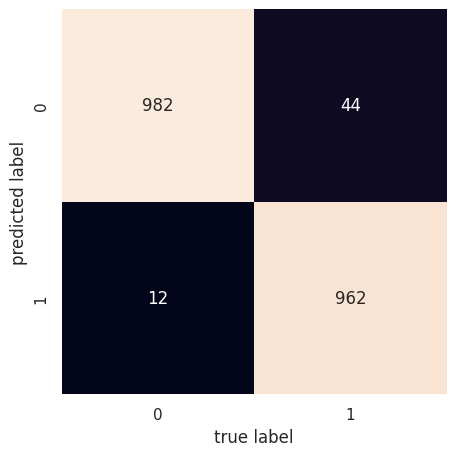

In [ ]:
get_confusion_matrix(y_test, y_pred)
get_f1_scores(y_test, y_pred)